We want to compute intra and inter network connectivty from covariance matrices, which should have been computed in `compare_maps.ipynb`

In [1]:
from init_nb import init_notebook
config = init_notebook()

from pathlib import Path
import joblib

from bold_dementia.connectivity.matrices import plot_matrices
from bold_dementia.connectivity.atlases import Atlas

ATLAS = "schaeffer"
SOFT = False
matrices_path = Path(
    f"{config['data_dir']}/output/connectivity/atlas-{ATLAS}_strategy-high_pass-motion-wm_csf_motion-full_wm_csf-basic"
)

In [2]:
AD_matrices = joblib.load(matrices_path / "AD.joblib")
control_matrices = joblib.load(matrices_path / "control.joblib")

AD = AD_matrices.mean(axis=0)
control = control_matrices.mean(axis=0)

atlas = Atlas.from_name(ATLAS, soft=SOFT)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FixedLocator

def plot_matrix(
    mat, atlas, macro_labels=True, bounds=None, cmap="seismic"
):
    mat = mat.copy()
    n_regions = mat.shape[0]
    mat[list(range(n_regions)), list(range(n_regions))] = 0
    

    # In general we want a colormap that is symmetric around 0
    span = max(abs(mat.min()), abs(mat.max()))
    if bounds is None:
        bounds = (-span, span)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    if macro_labels:
        networks = np.array(atlas.macro_labels)

        sort_index = np.argsort(networks)
        ticks = []
        lbls = []
        prev_label = None
        for i, label in enumerate(networks[sort_index]):
            if label != prev_label:
                ticks.append(i)
                lbls.append(label)
                prev_label = label
                ax.hlines(i, 0, n_regions, colors="black", linestyles="dotted")
                ax.vlines(i, 0, n_regions, colors="black", linestyles="dotted")

        ticks.append(i + 1)
        
    else:
        sort_index = np.arange(n_regions)

    
    sns.heatmap(
        mat[np.ix_(sort_index, sort_index)],
        ax=ax,
        vmin=bounds[0],
        vmax=bounds[1],
        cmap=cmap
    )

    if macro_labels:
        ax.yaxis.set_minor_locator(FixedLocator(ticks))
        ax.yaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax.xaxis.set_major_locator(FixedLocator([(t0 + t1) / 2 for t0, t1 in zip(ticks[:-1], ticks[1:])]))
        ax.set_yticklabels(lbls, rotation=0)
        ax.set_xticklabels(lbls, rotation=30)

    fig.tight_layout()
    return fig

    

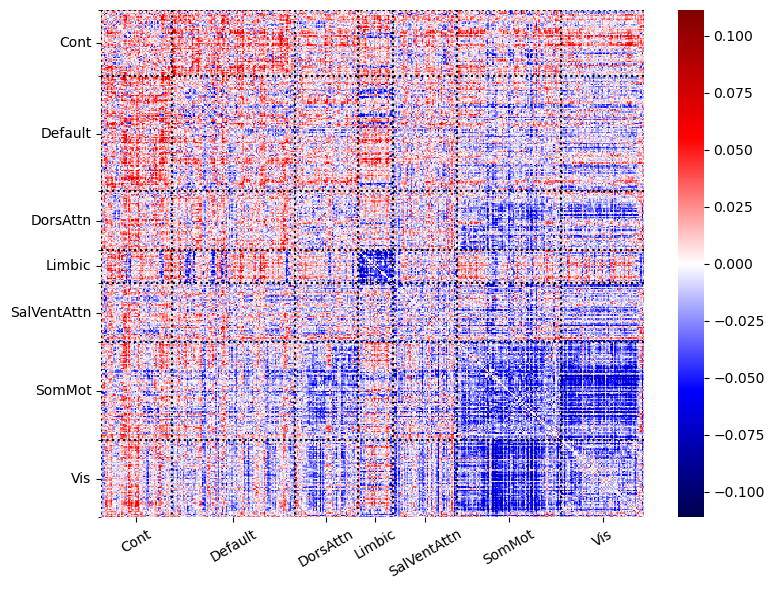

In [4]:
plot_matrix(AD_matrices.mean(axis=0) - control_matrices.mean(axis=0), atlas)
plt.show()